# Descarga y exploración

## 1. Imports y libreías

In [2]:
# Liberías para la descarga y exploración
!pip install gensim
!pip install numpy
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 2. Descarga

In [5]:
# Carga de datos
data = pd.read_json("Video_Games_5.json", lines=True)

# Vista rápida
data.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,"06 14, 2011"


In [6]:
# Muestreo proporcional de 5000 registros
total_sample = 5000
sample_data = data.groupby('overall', group_keys=False).apply(lambda x: x.sample(frac=total_sample/len(data), random_state=42))
sample_data.reset_index(drop=True, inplace=True)

## 3. Exploración


### 3.1 Cardinalidad del vocabulario

In [7]:
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', str(text).lower())
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return tokens

all_tokens = sample_data['reviewText'].dropna().apply(tokenize)
vocabulario = set([token for tokens in all_tokens for token in tokens])
print(f"Cardinalidad del vocabulario: {len(vocabulario)} palabras ")

Cardinalidad del vocabulario: 28670 palabras 


### 3.2 Distribución de reviews por número de estrellas

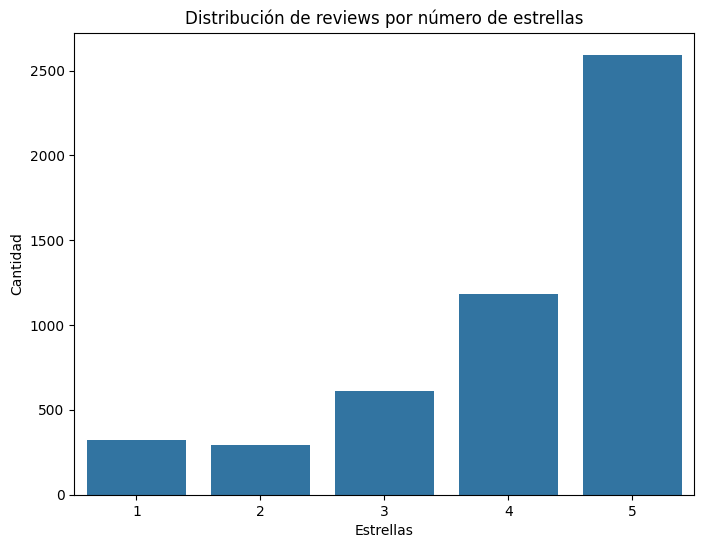

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='overall', data=sample_data)
plt.title('Distribución de reviews por número de estrellas')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad')
plt.show()

### 3.3 Nº de reviews positivas y negativas
En la instrucción original de la práctica dice que el objetivo final será:

*El enfoque será el de un problema de clasificación binaria supervisada.*

Esto significa que, al momento de entrenar el modelo, solo deberíamos tener dos clases:
- Positivo (por ejemplo, reviews con 4 o 5 estrellas)
- Negativo (reviews con 1 o 2 estrellas)

Las reviews neutrales (3 estrellas) seran excluidas en la etapa de entrenamiento para no introducir ruido.

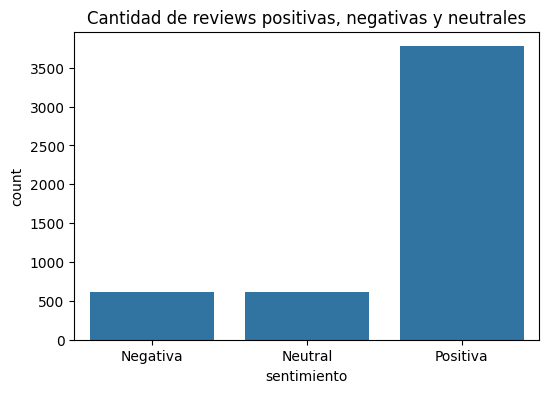

In [9]:
def clasificar_sentimiento(x):
    if x >= 4:
        return 'Positiva'
    elif x <= 2:
        return 'Negativa'
    else:
        return 'Neutral'

sample_data['sentimiento'] = sample_data['overall'].apply(clasificar_sentimiento)

plt.figure(figsize=(6,4))
sns.countplot(x='sentimiento', data=sample_data)
plt.title('Cantidad de reviews positivas, negativas y neutrales')
plt.show()

### 3.4 N-grams más frecuentes

In [10]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(sample_data['reviewText'].fillna(''))

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

print("Top 10 Bigramas más frecuentes:")
for bigrama, freq in words_freq[:10]:
    print(f"{bigrama}: {freq}")

Top 10 Bigramas más frecuentes:
game play: 471
great game: 374
play game: 330
game just: 286
ve played: 279
single player: 271
playing game: 257
fun game: 244
game like: 234
game really: 231


### 3.5 Nubes de palabras

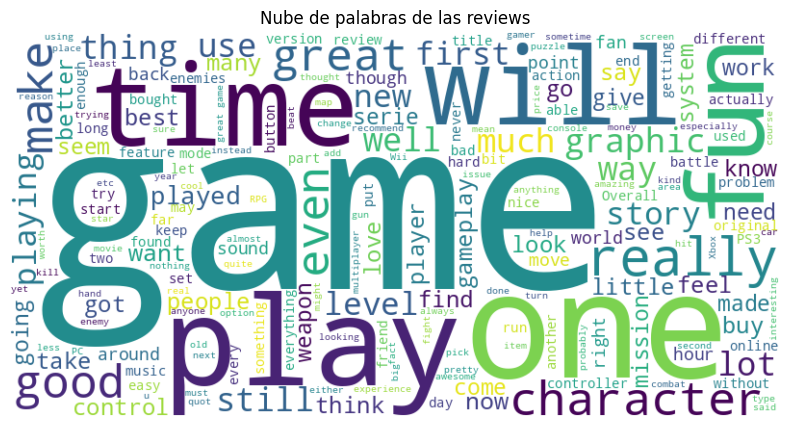

In [11]:
text = " ".join(review for review in sample_data['reviewText'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de las reviews')
plt.show()

### 3.6 Visualización word embeddings
Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

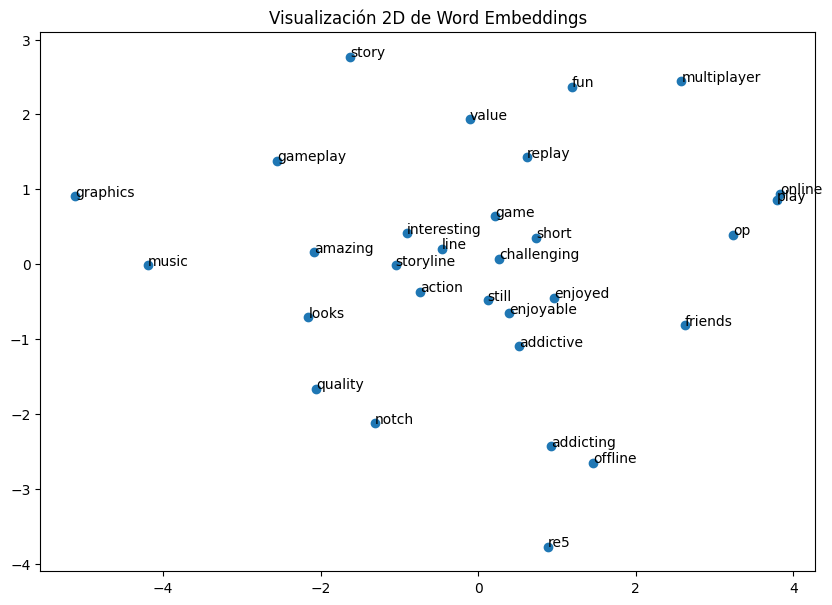

In [12]:
# Entrenar Word2Vec
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=2, workers=4, seed=42)

# Palabras a visualizar
palabras_objetivo = ['game', 'fun', 'play', 'graphics', 'story']

vectores = []
labels = []
for palabra in palabras_objetivo:
    if palabra in w2v_model.wv:
        labels.append(palabra)
        vectores.append(w2v_model.wv[palabra])
        for similar, _ in w2v_model.wv.most_similar(palabra, topn=5):
            labels.append(similar)
            vectores.append(w2v_model.wv[similar])

vectores = np.array(vectores)

# Reducción a 2D
pca = PCA(n_components=2)
vectores_2d = pca.fit_transform(vectores)

plt.figure(figsize=(10,7))
plt.scatter(vectores_2d[:, 0], vectores_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (vectores_2d[i, 0], vectores_2d[i, 1]))

plt.title('Visualización 2D de Word Embeddings')
plt.show()

### 3.7 Conclusiones de la exploración

Observaciones:
Durante la exploración inicial, detecto que la eliminación de stopwords podría estar eliminando términos críticos en el análisis de sentimiento, como ocurre con "to" que forma parte de expresiones relevantes en videojuegos como "p2w" (pay to win).

Esto motiva a realizar un análisis separado de positivas y negativas, considerando cómo ciertos n-grams podrían verse afectados.


### 3.8 Cualquier otra métrica / exploración / cálculo que el alumno considere

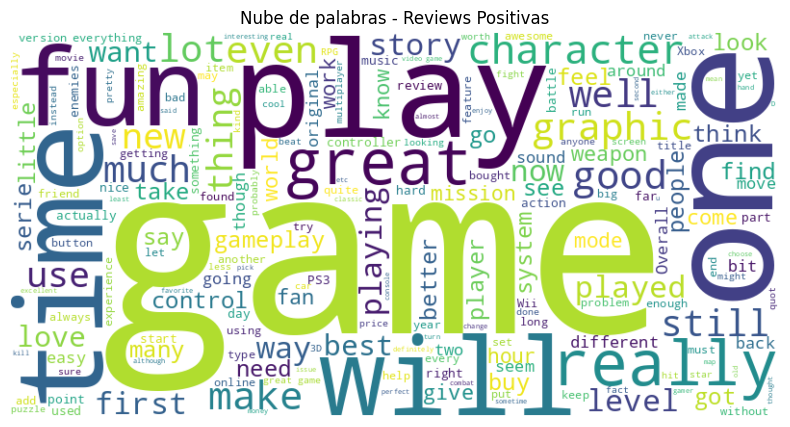

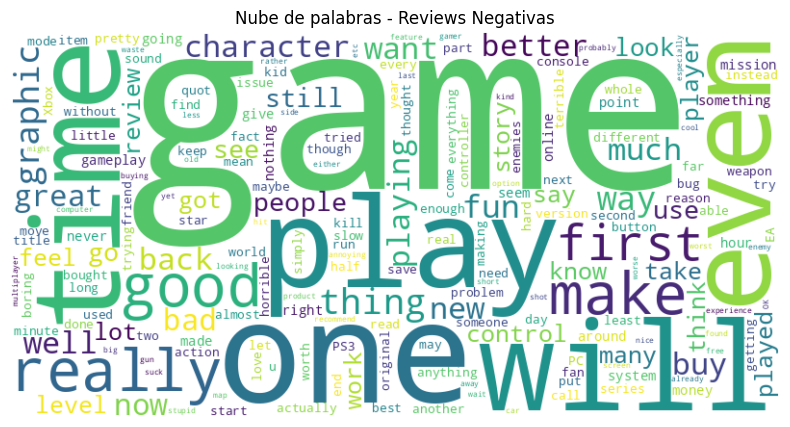

Top 10 Bigramas - Positivas:
grand theft auto: 51
game ve played: 43
highly recommend game: 42
lego star wars: 31
pok eacute mon: 31
metal gear solid: 29
games ve played: 28
game lot fun: 27
single player campaign: 27
super mario bros: 27
Top 10 Bigramas - Negativas:
smackdown vs raw: 9
guitar hero wt: 8
don buy game: 7
don waste money: 6
quot lionheart quot: 6
generic loner badass: 6
don waste time: 5
like previous games: 5
loner badass 7001: 5
waste time money: 4


In [19]:
# Recalcular nube de palabras y n-grams por polaridad positiva y negativa
positivas = sample_data[sample_data['sentimiento'] == 'Positiva']
negativas = sample_data[sample_data['sentimiento'] == 'Negativa']

# Wordcloud positiva
text_pos = " ".join(review for review in positivas['reviewText'].dropna())
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(text_pos)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Reviews Positivas')
plt.show()

# Wordcloud negativa
text_neg = " ".join(review for review in negativas['reviewText'].dropna())
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(text_neg)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Reviews Negativas')
plt.show()

# Bigramas positivas
vectorizer_pos = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_pos = vectorizer_pos.fit_transform(positivas['reviewText'].fillna(''))
sum_words_pos = X_pos.sum(axis=0)
words_freq_pos = [(word, sum_words_pos[0, idx]) for word, idx in vectorizer_pos.vocabulary_.items()]
words_freq_pos = sorted(words_freq_pos, key = lambda x: x[1], reverse=True)

print("Top 10 Bigramas - Positivas:")
for bigrama, freq in words_freq_pos[:10]:
    print(f"{bigrama}: {freq}")

# Bigramas negativas
vectorizer_neg = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_neg = vectorizer_neg.fit_transform(negativas['reviewText'].fillna(''))
sum_words_neg = X_neg.sum(axis=0)
words_freq_neg = [(word, sum_words_neg[0, idx]) for word, idx in vectorizer_neg.vocabulary_.items()]
words_freq_neg = sorted(words_freq_neg, key = lambda x: x[1], reverse=True)

print("Top 10 Bigramas - Negativas:")
for bigrama, freq in words_freq_neg[:10]:
    print(f"{bigrama}: {freq}")

### 3.9 Reflexión adicional

Aparaentemente no existe el problema previsto, aun así creo que fue importante revisar estas posiblilidades, por ahora veo un enfoque típico en el tratamiento de los reviews, mantendré las stopwords como hasta ahora

## 4. Guardado

In [20]:
sample_data.to_csv('sampled_video_games_reviews.csv', index=False)

## 5. Comentarios

Tras revisar los reviews, no parece que requieran un preprocesamiento intensivo ni una manipulación significativa de los datos; es posible que el dataset esté ya bastante limpio.

El único problema que detecto es el fuerte desbalanceo: a diferencia de otros conjuntos de reseñas, en el caso de los videojuegos hay una tendencia marcada hacia valoraciones positivas. Inicialmente había pensado en eliminar las opiniones neutrales (3 estrellas) para reducir el ruido, pero he decidido considerarlas como negativas. De este modo, mejoraré ligeramente el balance sin alterar artificialmente la distribución real de los datos. No tengo intención de forzar un balanceo artificial, ya que quiero que el modelo se entrene respetando las características reales del conjunto de datos.